In [5]:
!pip install scikit-fuzzy scikit-learn matplotlib pandas seaborn --quiet

import os, pickle, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

sns.set(style="whitegrid")
ARTIFACT_DIR = "artifacts"
PLOTS_DIR = os.path.join(ARTIFACT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

def mf_centroid(universe, mf):
    denom = np.sum(mf)
    if denom == 0:
        return np.mean(universe)
    return float(np.sum(universe * mf) / denom)

class RobustFuzzyResearchModel:
    def __init__(self):

        self.Water      = ctrl.Antecedent(np.arange(0,4.1,0.1), 'Water')
        self.Sleep      = ctrl.Antecedent(np.arange(0,13,0.1), 'Sleep')
        self.Stress     = ctrl.Antecedent(np.arange(0,11,1), 'Stress')
        self.Junk       = ctrl.Antecedent(np.arange(0,2,1), 'Junk')
        self.Oily       = ctrl.Antecedent(np.arange(0,2,1), 'Oily')
        self.Spicy      = ctrl.Antecedent(np.arange(0,2,1), 'Spicy')
        self.HighFat    = ctrl.Antecedent(np.arange(0,2,1), 'HighFat')
        self.Carbon     = ctrl.Antecedent(np.arange(0,3,1), 'Carbon')
        self.Meals      = ctrl.Antecedent(np.arange(1,7,1), 'Meals')
        self.Exercise   = ctrl.Antecedent(np.arange(0,21,1), 'Exercise')
        self.DinnerHour = ctrl.Antecedent(np.arange(16,25,1), 'DinnerHour')
        self.BMI        = ctrl.Antecedent(np.arange(12,46,1), 'BMI')
        self.Acidity    = ctrl.Antecedent(np.arange(0,2,1), 'Acidity')
        self.Gastritis  = ctrl.Antecedent(np.arange(0,2,1), 'Gastritis')
        self.IBS        = ctrl.Antecedent(np.arange(0,2,1), 'IBS')

        self.Age        = ctrl.Antecedent(np.arange(10,91,1), 'Age')

        self.Risk       = ctrl.Consequent(np.arange(0,101,1), 'Risk')
        self.Severity   = ctrl.Consequent(np.arange(0,11,1), 'Severity')

        self.Water['low']    = fuzz.trimf(self.Water.universe, [0,0.5,1.5])
        self.Water['medium'] = fuzz.trimf(self.Water.universe, [1,2,3])
        self.Water['high']   = fuzz.trimf(self.Water.universe, [2.5,3.5,4.0])

        # Sleep
        self.Sleep['poor']   = fuzz.trimf(self.Sleep.universe, [0,3,6])
        self.Sleep['normal'] = fuzz.trimf(self.Sleep.universe, [5,7,9])
        self.Sleep['good']   = fuzz.trimf(self.Sleep.universe, [8,10,12])

        # Stress
        self.Stress['low']    = fuzz.trimf(self.Stress.universe, [0,2,4])
        self.Stress['medium'] = fuzz.trimf(self.Stress.universe, [3,5,7])
        self.Stress['high']   = fuzz.trimf(self.Stress.universe, [6,8,10])

        # Binary flags
        for v in [self.Junk, self.Oily, self.Spicy, self.HighFat, self.Acidity, self.Gastritis, self.IBS]:
            v['no']  = fuzz.trimf(v.universe, [0,0,1])
            v['yes'] = fuzz.trimf(v.universe, [0,1,1])

        # Carbonation
        self.Carbon['never']      = fuzz.trimf(self.Carbon.universe, [0,0,1])
        self.Carbon['occasional'] = fuzz.trimf(self.Carbon.universe, [0,1,2])
        self.Carbon['frequent']   = fuzz.trimf(self.Carbon.universe, [1,2,2])

        # Meals
        self.Meals['low']    = fuzz.trimf(self.Meals.universe, [1,1,2])
        self.Meals['medium'] = fuzz.trimf(self.Meals.universe, [2,3,4])
        self.Meals['high']   = fuzz.trimf(self.Meals.universe, [4,5,6])

        # Exercise
        self.Exercise['low']    = fuzz.trimf(self.Exercise.universe, [0,0,4])
        self.Exercise['medium'] = fuzz.trimf(self.Exercise.universe, [3,7,12])
        self.Exercise['high']   = fuzz.trimf(self.Exercise.universe, [10,15,20])

        # DinnerHour
        self.DinnerHour['early']  = fuzz.trimf(self.DinnerHour.universe, [16,17,18])
        self.DinnerHour['normal'] = fuzz.trimf(self.DinnerHour.universe, [18,19,21])
        self.DinnerHour['late']   = fuzz.trimf(self.DinnerHour.universe, [21,22,24])

        # BMI
        self.BMI['normal']     = fuzz.trimf(self.BMI.universe, [12,20,25])
        self.BMI['overweight'] = fuzz.trimf(self.BMI.universe, [24,28,32])
        self.BMI['obese']      = fuzz.trimf(self.BMI.universe, [30,36,45])

        # ⭐ AGE MEMBERSHIP FUNCTIONS
        self.Age['young']  = fuzz.trimf(self.Age.universe, [10,20,35])
        self.Age['middle'] = fuzz.trimf(self.Age.universe, [30,45,60])
        self.Age['old']    = fuzz.trimf(self.Age.universe, [55,70,85])

        # Risk output
        self.Risk['low']      = fuzz.trimf(self.Risk.universe, [0,10,30])
        self.Risk['moderate'] = fuzz.trimf(self.Risk.universe, [25,50,75])
        self.Risk['high']     = fuzz.trimf(self.Risk.universe, [70,85,100])

        # Severity output
        self.Severity['mild']     = fuzz.trimf(self.Severity.universe, [0,2,4])
        self.Severity['moderate'] = fuzz.trimf(self.Severity.universe, [3,5,7])
        self.Severity['severe']   = fuzz.trimf(self.Severity.universe, [6,8,10])

        RS = []

        # Medical
        RS.append((self.Acidity['yes'], 'high', 'moderate'))
        RS.append((self.Gastritis['yes'], 'high', 'moderate'))
        RS.append((self.IBS['yes'], 'high', 'severe'))

        # Age-based (NEW)
        RS.append((self.Age['young'], 'low', 'mild'))
        RS.append((self.Age['middle'], 'moderate', 'moderate'))
        RS.append((self.Age['old'], 'high', 'moderate'))

        # Diet & lifestyle rules (unchanged)
        RS.append((self.Junk['yes'] & self.Oily['yes'], 'high', 'moderate'))
        RS.append((self.Spicy['yes'] & self.HighFat['yes'], 'high', 'moderate'))
        RS.append((self.Carbon['frequent'], 'high', 'moderate'))
        RS.append((self.Sleep['poor'] & self.Stress['high'], 'high', 'moderate'))
        RS.append((self.DinnerHour['late'] & self.Meals['high'], 'high', 'moderate'))
        RS.append((self.BMI['obese'] & self.Exercise['low'], 'high', 'moderate'))
        RS.append((self.BMI['normal'] & self.Exercise['high'], 'low', 'mild'))
        RS.append((self.Water['high'] & self.Sleep['good'], 'low', 'mild'))
        RS.append((self.Water['medium'] & self.Sleep['normal'], 'moderate', 'moderate'))
        RS.append((self.Meals['medium'], 'moderate', 'moderate'))
        RS.append((self.Spicy['yes'] & self.Carbon['occasional'], 'moderate', 'moderate'))
        RS.append((self.Junk['yes'] & self.Sleep['poor'], 'high', 'moderate'))
        RS.append((self.Water['low'] & self.Junk['yes'], 'high', 'moderate'))
        RS.append((self.Stress['high'], 'high', 'moderate'))
        RS.append((self.Sleep['normal'], 'moderate', 'mild'))
        RS.append((self.Water['high'] & self.Exercise['high'], 'low', 'mild'))
        RS.append((self.Meals['low'] & self.BMI['normal'], 'low', 'mild'))
        RS.append((self.DinnerHour['early'] & self.Sleep['good'], 'low', 'mild'))
        RS.append((self.Meals['high'] & self.Oily['yes'], 'high', 'moderate'))
        RS.append((self.Meals['low'] & self.Stress['high'], 'moderate', 'moderate'))
        RS.append((self.Carbon['frequent'] & self.Sleep['poor'], 'high', 'moderate'))
        RS.append((self.Junk['yes'] & self.Oily['yes'] & self.Spicy['yes'], 'high', 'severe'))
        RS.append((self.Water['medium'] & self.Sleep['normal'], 'moderate', 'moderate'))

        # Build control systems
        risk_rules = []
        sev_rules  = []

        for antecedent, rterm, sterm in RS:
            risk_rules.append(ctrl.Rule(antecedent, self.Risk[rterm]))
            sev_rules.append(ctrl.Rule(antecedent, self.Severity[sterm]))

        # Fallback
        risk_rules.append(ctrl.Rule(self.Water['medium'] & self.Sleep['normal'], self.Risk['moderate']))
        sev_rules.append(ctrl.Rule(self.Water['medium'] & self.Sleep['normal'], self.Severity['moderate']))

        self.control_risk = ctrl.ControlSystem(risk_rules)
        self.control_sev  = ctrl.ControlSystem(sev_rules)

        self.risk_centroids = {
            term: mf_centroid(self.Risk.universe, self.Risk[term].mf)
            for term in ['low','moderate','high']
        }

        self.sev_centroids = {
            term: mf_centroid(self.Severity.universe, self.Severity[term].mf)
            for term in ['mild','moderate','severe']
        }

        self.risk_fallback = np.mean(list(self.risk_centroids.values()))
        self.sev_fallback  = np.mean(list(self.sev_centroids.values()))

    def predict(self, inputs):

        defaults = {
            'Water':2.0,'Sleep':7.0,'Stress':3.0,'Junk':0,'Oily':0,'Spicy':0,'HighFat':0,
            'Carbon':0,'Meals':3,'Exercise':3,'DinnerHour':19,'BMI':24,'Acidity':0,
            'Gastritis':0,'IBS':0, 'Age':25
        }

        inp = {k: inputs.get(k, defaults[k]) for k in defaults}

        # Clamp values
        inp['Water'] = float(np.clip(inp['Water'], 0, 4))
        inp['Sleep'] = float(np.clip(inp['Sleep'], 0, 12))
        inp['Stress'] = float(np.clip(inp['Stress'], 0,10))
        inp['Meals'] = int(np.clip(inp['Meals'],1,6))
        inp['DinnerHour'] = int(np.clip(inp['DinnerHour'],16,24))
        inp['Exercise'] = float(np.clip(inp['Exercise'],0,20))
        inp['BMI'] = float(np.clip(inp['BMI'],12,45))
        inp['Carbon'] = int(np.clip(inp['Carbon'],0,2))
        inp['Age'] = int(np.clip(inp['Age'],10,90))

        for b in ['Junk','Oily','Spicy','HighFat','Acidity','Gastritis','IBS']:
            inp[b] = 1 if inp[b] else 0

        # Compute fuzzy RISK
        try:
            sim_r = ctrl.ControlSystemSimulation(self.control_risk)
            for k,v in inp.items(): sim_r.input[k] = v
            sim_r.compute()
            risk_val = float(sim_r.output.get('Risk', np.nan))
        except:
            risk_val = np.nan

        # Compute fuzzy SEVERITY
        try:
            sim_s = ctrl.ControlSystemSimulation(self.control_sev)
            for k,v in inp.items(): sim_s.input[k] = v
            sim_s.compute()
            sev_val = float(sim_s.output.get('Severity', np.nan))
        except:
            sev_val = np.nan

        # Fallbacks
        if np.isnan(risk_val): risk_val = self.risk_fallback
        if np.isnan(sev_val):  sev_val  = self.sev_fallback

        risk_val = float(np.clip(risk_val,0,100))
        sev_val  = float(np.clip(sev_val,0,10))

        annual_growth = 1.2
        if risk_val >= 70:
            yhr = 0
        else:
            yhr = round((70 - risk_val) / annual_growth, 1)
            yhr = max(yhr, 0)

        return {
            'Risk': risk_val,
            'Severity': sev_val,
            'YearsToHighRisk': yhr
        }

# 4) Build & save model
MODEL_PATH = os.path.join(ARTIFACT_DIR, "robust_fuzzy_research_model.pkl")
model = RobustFuzzyResearchModel()
with open(MODEL_PATH, "wb") as f:
    pickle.dump(model, f)
print("Robust fuzzy model saved to", MODEL_PATH)

# 5) Synthetic data generator (realistic distributions)
def generate_synthetic(n=5000, seed=42):
    np.random.seed(seed)
    df = pd.DataFrame({
    "Water": np.clip(np.random.normal(2.0, 0.8, n), 0.1, 4.0),
    "Sleep": np.clip(np.random.normal(7.0, 1.5, n), 3.0, 12.0),
    "Stress": np.clip(np.random.normal(4.0, 2.0, n), 0.0, 10.0),
    "Junk": np.random.binomial(1, 0.35, n),
    "Oily": np.random.binomial(1, 0.30, n),
    "Spicy": np.random.binomial(1, 0.40, n),
    "HighFat": np.random.binomial(1, 0.25, n),
    "Carbon": np.random.choice([0,1,2], n, p=[0.5,0.3,0.2]),
    "Meals": np.random.randint(1,7,n),
    "Exercise": np.clip(np.random.normal(4.0, 3.0, n), 0.0, 20.0),
    "DinnerHour": np.random.choice([17,18,19,20,21,22,23,24], n),
    "BMI": np.clip(np.random.normal(24.0, 4.0, n), 14.0, 45.0),
    "Acidity": np.random.binomial(1, 0.20, n),
    "Gastritis": np.random.binomial(1, 0.12, n),
    "IBS": np.random.binomial(1, 0.08, n),

    # ⭐ NEW FEATURE ADDED
    "Age": np.random.randint(15, 80, n)
})
    return df

# 6) Label synthetic dataset with model (guaranteed no-NaN outputs)
synthetic = generate_synthetic(5000)
with open(MODEL_PATH, "rb") as f:
    loaded = pickle.load(f)

def label_with_model(df, fis_model):
    risks, sevs, yhrs = [], [], []
    for _, row in df.iterrows():
        out = fis_model.predict(row.to_dict())
        risks.append(out['Risk'])
        sevs.append(out['Severity'])
        yhrs.append(out['YearsToHighRisk'])
    df['Risk'] = risks
    df['Severity'] = sevs
    df['YearsToHighRisk'] = yhrs
    return df

synthetic_labeled = label_with_model(synthetic, loaded)
CSV_PATH = os.path.join(ARTIFACT_DIR, "synthetic_fuzzy_dataset.csv")
synthetic_labeled.to_csv(CSV_PATH, index=False)
print(f"Generated and labeled {len(synthetic_labeled)} synthetic samples -> {CSV_PATH}")

# Quick check: any NaNs?
print("Any NaNs in Risk or Severity columns?:", synthetic_labeled[['Risk','Severity']].isna().any().any())

# 7) EDA: summary, histograms, heatmap, save plots
print("\nDataset sample:")
print(synthetic_labeled.head())

summary = synthetic_labeled.describe()
summary.to_csv(os.path.join(ARTIFACT_DIR, "dataset_summary.csv"))
print("Summary saved.")

# Histograms (compact grid)
plot_cols = ['Water','Sleep','Stress','Meals','Exercise','BMI','Risk','Severity']
plt.figure(figsize=(12,8))
for i, col in enumerate(plot_cols, 1):
    plt.subplot(3,3,i)
    sns.histplot(synthetic_labeled[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "histograms_grid.png"), dpi=150)
plt.close()

# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(synthetic_labeled.corr(), cmap="vlag", center=0)
plt.title("Correlation heatmap")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "correlation_heatmap.png"), dpi=150)
plt.close()

# 8) Membership function plots (important vars)
def plot_mfs(var, save_name):
    plt.figure(figsize=(6,3.5))
    for term in var.terms:
        mf = var[term].mf
        plt.plot(var.universe, mf, label=term)
    plt.title(var.label + " MFs")
    plt.xlabel(var.label)
    plt.ylabel("membership")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, save_name), dpi=150)
    plt.close()

plot_mfs(loaded.Water, "mf_water.png")
plot_mfs(loaded.Sleep, "mf_sleep.png")
plot_mfs(loaded.Stress, "mf_stress.png")
plot_mfs(loaded.Risk, "mf_risk.png")
print("MF plots saved to", PLOTS_DIR)

# 9) Sensitivity analysis (Stress & Water)
def sensitivity(fis, base, var, sweep):
    rows = []
    for v in sweep:
        inp = base.copy()
        inp[var] = v
        out = fis.predict(inp)
        rows.append((v, out['Risk'], out['Severity']))
    return pd.DataFrame(rows, columns=[var,'Risk','Severity'])

baseline = {'Water':2.0,'Sleep':7.0,'Stress':3.0,'Junk':0,'Oily':0,'Spicy':0,'HighFat':0,
            'Carbon':0,'Meals':3,'Exercise':3,'DinnerHour':19,'BMI':24,'Acidity':0,'Gastritis':0,'IBS':0}

sweep_stress = np.arange(0,11,1)
sens_stress = sensitivity(loaded, baseline, 'Stress', sweep_stress)
sens_stress.plot(x='Stress', y='Risk', marker='o', title='Sensitivity: Risk vs Stress', legend=False)
plt.savefig(os.path.join(PLOTS_DIR, "sensitivity_stress.png"), dpi=150)
plt.close()

sweep_water = np.linspace(0,4,21)
sens_water = sensitivity(loaded, baseline, 'Water', sweep_water)
sens_water.plot(x='Water', y='Risk', marker='o', title='Sensitivity: Risk vs Water', legend=False)
plt.savefig(os.path.join(PLOTS_DIR, "sensitivity_water.png"), dpi=150)
plt.close()

# 10) ML approximation — RandomForest regressors for Risk & Severity
X = synthetic_labeled.drop(columns=['Risk','Severity']).astype(float)
y_risk = synthetic_labeled['Risk'].astype(float)
y_sev  = synthetic_labeled['Severity'].astype(float)

# Train/test split for Risk
X_train, X_test, y_train, y_test = train_test_split(X, y_risk, test_size=0.2, random_state=42)
rf_risk = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_risk.fit(X_train, y_train)
pred_r = rf_risk.predict(X_test)
mae_r = mean_absolute_error(y_test, pred_r)
r2_r = r2_score(y_test, pred_r)
print(f"\nRandomForest (Risk) MAE: {mae_r:.3f}, R2: {r2_r:.3f}")

# Train/test for Severity
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sev, test_size=0.2, random_state=42)
rf_sev = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_sev.fit(X_train_s, y_train_s)
pred_s = rf_sev.predict(X_test_s)
mae_s = mean_absolute_error(y_test_s, pred_s)
r2_s = r2_score(y_test_s, pred_s)
print(f"RandomForest (Severity) MAE: {mae_s:.3f}, R2: {r2_s:.3f}")

# Save RF models
with open(os.path.join(ARTIFACT_DIR, "rf_risk.pkl"), "wb") as f:
    pickle.dump(rf_risk, f)
with open(os.path.join(ARTIFACT_DIR, "rf_sev.pkl"), "wb") as f:
    pickle.dump(rf_sev, f)

# Feature importances
feat_imp = pd.Series(rf_risk.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.head(12).to_csv(os.path.join(ARTIFACT_DIR, "feature_importances_risk.csv"))
print("\nTop features (Risk):")
print(feat_imp.head(12))

# 11) Save artifacts summary
summary_text = f"""
Professional Fuzzy Project Artifacts
===================================
Samples: {len(synthetic_labeled)}
Model file: {MODEL_PATH}
Dataset CSV: {CSV_PATH}
RF Risk model: {os.path.join(ARTIFACT_DIR,'rf_risk.pkl')}
RF Severity model: {os.path.join(ARTIFACT_DIR,'rf_sev.pkl')}

RandomForest Risk -> MAE: {mae_r:.3f}, R2: {r2_r:.3f}
RandomForest Severity -> MAE: {mae_s:.3f}, R2: {r2_s:.3f}

Top features for Risk:
{feat_imp.head(12).to_string()}
"""
with open(os.path.join(ARTIFACT_DIR, "project_summary.txt"), "w") as f:
    f.write(summary_text)

print("\nAll artifacts saved to folder:", ARTIFACT_DIR)
print("Plots in:", PLOTS_DIR)

# 12) Quick terminal demo function (optional)
def quick_demo():
    print("\nQuick demo (Enter uses default):")
    def rd(q,d):
        s = input(f"{q} [{d}]: ").strip()
        return float(s) if s else d
    Water = rd("Water (L/day)", 2.0)
    Sleep = rd("Sleep hours", 7.0)
    Stress = rd("Stress (0-10)", 3.0)
    Junk = rd("Junk (0/1)", 0)
    Oily = rd("Oily (0/1)", 0)
    Spicy = rd("Spicy (0/1)", 0)
    HighFat = rd("HighFat (0/1)", 0)
    Carbon = rd("Carbon (0/1/2)", 0)
    Meals = rd("Meals/day", 3)
    Exercise = rd("Exercise hrs/week", 3)
    DinnerHour = rd("Dinner hour", 19)
    BMI = rd("BMI", 24)
    Acidity = rd("Acidity (0/1)", 0)
    Gastritis = rd("Gastritis (0/1)", 0)
    IBS = rd("IBS (0/1)", 0)
    inp = {'Water':Water,'Sleep':Sleep,'Stress':Stress,'Junk':Junk,'Oily':Oily,'Spicy':Spicy,'HighFat':HighFat,
           'Carbon':Carbon,'Meals':Meals,'Exercise':Exercise,'DinnerHour':DinnerHour,'BMI':BMI,'Acidity':Acidity,
           'Gastritis':Gastritis,'IBS':IBS}
    out = loaded.predict(inp)
    print("Predicted Risk:", round(out['Risk'],2), "/100")
    print("Predicted Severity:", round(out['Severity'],2), "/10")

Robust fuzzy model saved to artifacts/robust_fuzzy_research_model.pkl
Generated and labeled 5000 synthetic samples -> artifacts/synthetic_fuzzy_dataset.csv
Any NaNs in Risk or Severity columns?: False

Dataset sample:
      Water     Sleep    Stress  Junk  Oily  Spicy  HighFat  Carbon  Meals  \
0  2.397371  6.364360  2.643011     0     0      0        0       0      2   
1  1.889389  6.319879  3.389001     0     0      1        0       1      1   
2  2.518151  4.306535  2.805238     1     0      0        0       1      6   
3  3.218424  6.504865  4.220836     0     1      0        1       0      6   
4  1.812677  8.099244  6.394357     1     0      1        0       2      6   

   Exercise  DinnerHour        BMI  Acidity  Gastritis  IBS  Age       Risk  \
0  4.100600          23  24.763950        0          0    0   61  60.361338   
1  4.843322          22  28.078702        0          0    0   41  50.000000   
2  2.032722          21  16.223053        0          0    0   29  53.705962 

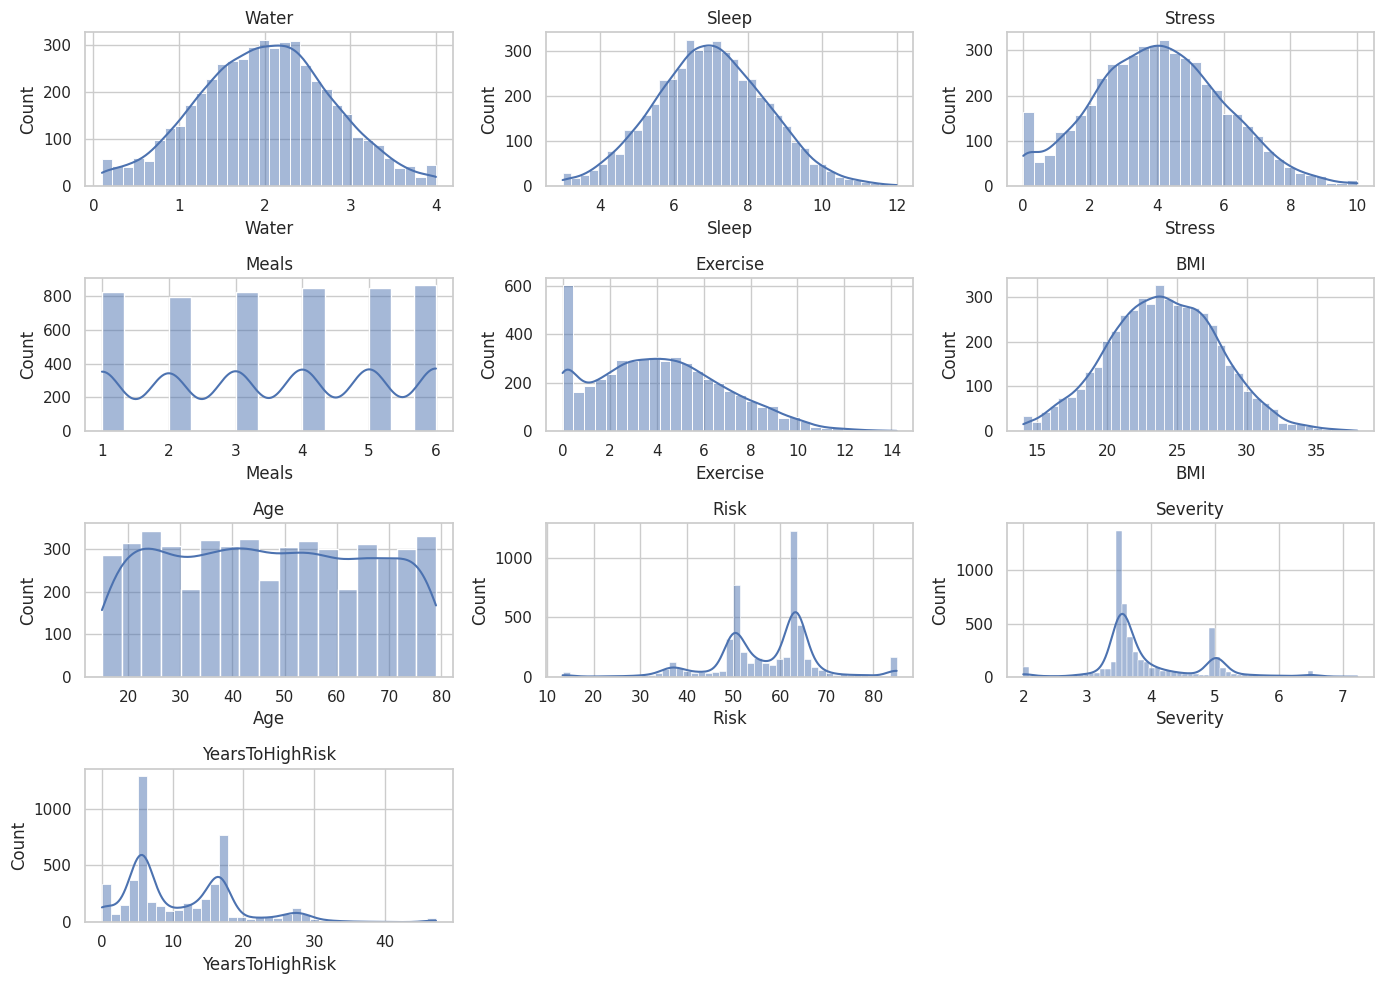

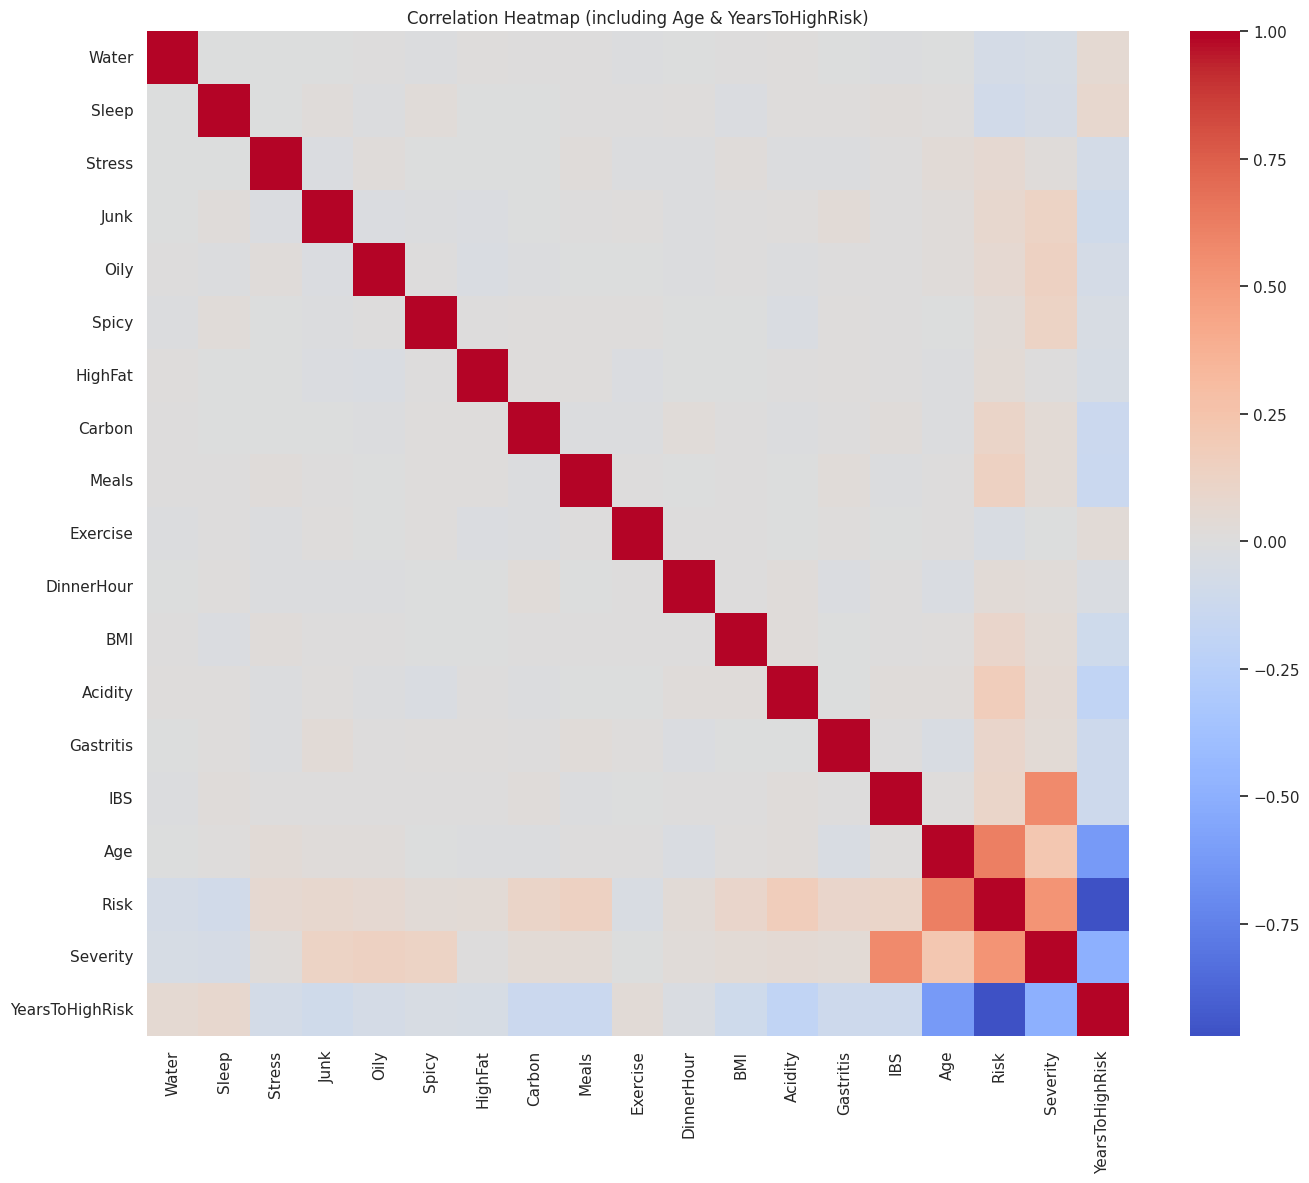

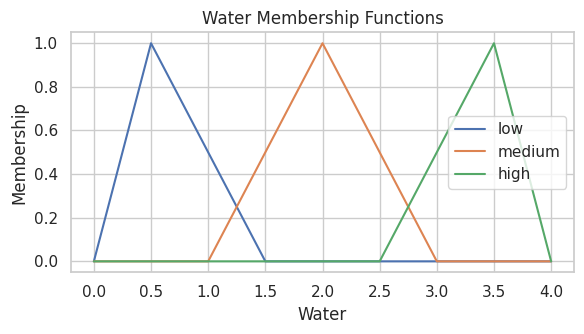

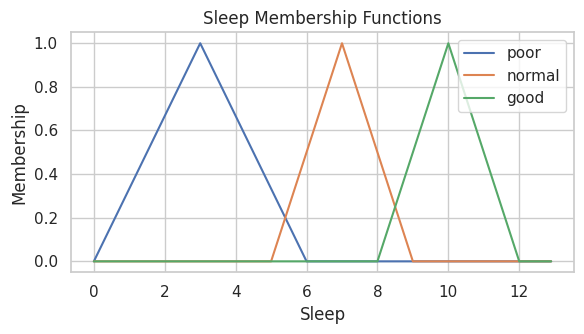

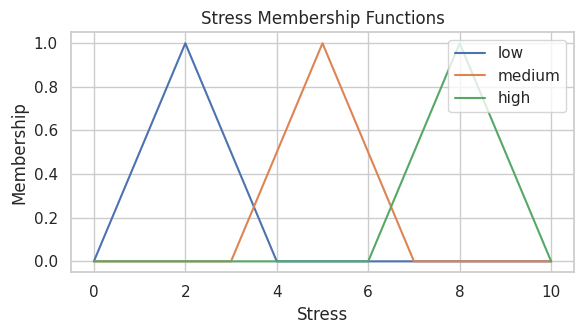

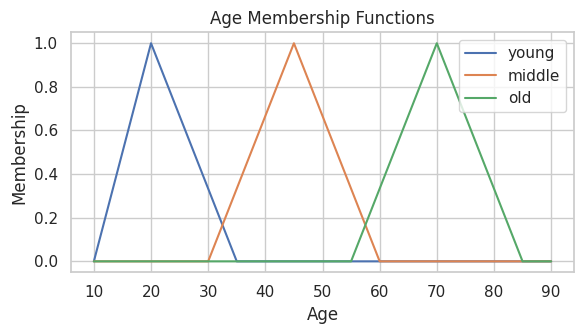

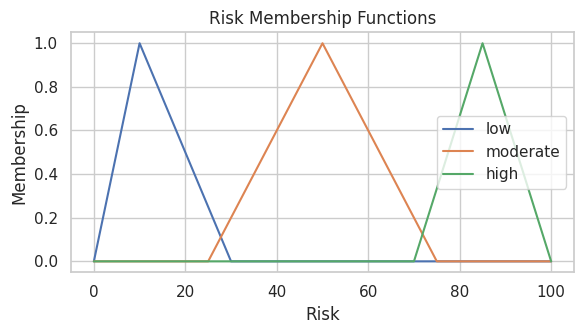

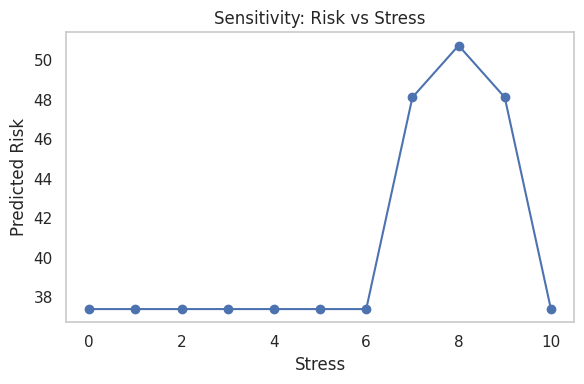

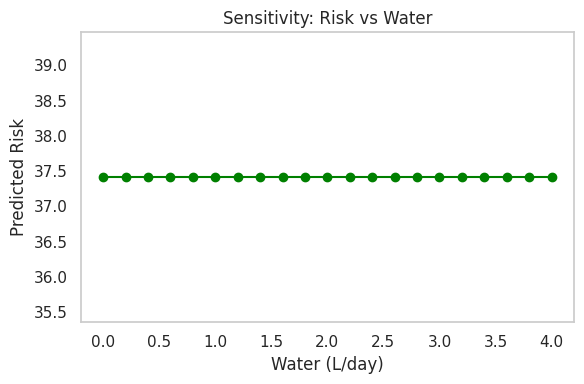

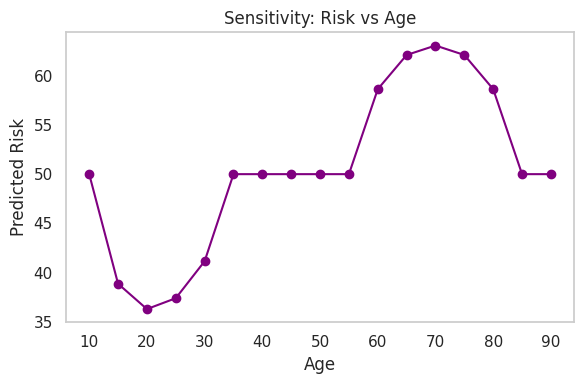

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid")

import os
if not os.path.exists("artifacts"):
    os.makedirs("artifacts")
if not os.path.exists("artifacts/plots"):
    os.makedirs("artifacts/plots")

PLOTS_DIR = "artifacts/plots"

def plot_histograms(df):
    cols = ['Water','Sleep','Stress','Meals','Exercise','BMI','Age',
            'Risk','Severity','YearsToHighRisk']

    plt.figure(figsize=(14,10))
    for i, col in enumerate(cols, 1):
        plt.subplot(4,3,i)
        sns.histplot(df[col], kde=True)
        plt.title(col)
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/histograms_updated.png", dpi=150)
    plt.show()

plot_histograms(synthetic_labeled)

plt.figure(figsize=(14,12))
sns.heatmap(synthetic_labeled.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (including Age & YearsToHighRisk)")
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/correlation_heatmap_updated.png", dpi=150)
plt.show()

def plot_mfs(var, filename):
    plt.figure(figsize=(6,3.5))
    for term in var.terms:
        plt.plot(var.universe, var[term].mf, label=term)
    plt.title(var.label + " Membership Functions")
    plt.xlabel(var.label)
    plt.ylabel("Membership")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/{filename}", dpi=150)
    plt.show()

plot_mfs(loaded.Water, "mf_water.png")
plot_mfs(loaded.Sleep, "mf_sleep.png")
plot_mfs(loaded.Stress, "mf_stress.png")
plot_mfs(loaded.Age, "mf_age.png")
plot_mfs(loaded.Risk, "mf_risk.png")

def sensitivity(fis, base, var, sweep):
    out = []
    for v in sweep:
        inp = base.copy()
        inp[var] = v
        r = fis.predict(inp)
        out.append([v, r["Risk"]])
    return np.array(out)

baseline = {
    'Water':2.0,'Sleep':7.0,'Stress':3.0,'Junk':0,'Oily':0,'Spicy':0,'HighFat':0,
    'Carbon':0,'Meals':3,'Exercise':3,'DinnerHour':19,'BMI':24,
    'Acidity':0,'Gastritis':0,'IBS':0, 'Age':25
}

# --- Stress Sweep ---
stress_vals = np.arange(0,11,1)
stress_res = sensitivity(loaded, baseline, "Stress", stress_vals)

plt.figure(figsize=(6,4))
plt.plot(stress_res[:,0], stress_res[:,1], marker='o')
plt.title("Sensitivity: Risk vs Stress")
plt.xlabel("Stress")
plt.ylabel("Predicted Risk")
plt.grid()
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/sensitivity_stress.png", dpi=150)
plt.show()

# --- Water Sweep ---
water_vals = np.linspace(0,4,21)
water_res = sensitivity(loaded, baseline, "Water", water_vals)

plt.figure(figsize=(6,4))
plt.plot(water_res[:,0], water_res[:,1], marker='o', color='green')
plt.title("Sensitivity: Risk vs Water")
plt.xlabel("Water (L/day)")
plt.ylabel("Predicted Risk")
plt.grid()
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/sensitivity_water.png", dpi=150)
plt.show()

# --- Age Sweep (NEW) ---
age_vals = np.arange(10,91,5)
age_res = sensitivity(loaded, baseline, "Age", age_vals)

plt.figure(figsize=(6,4))
plt.plot(age_res[:,0], age_res[:,1], marker='o', color='purple')
plt.title("Sensitivity: Risk vs Age")
plt.xlabel("Age")
plt.ylabel("Predicted Risk")
plt.grid()
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/sensitivity_age.png", dpi=150)
plt.show()

def quick_demo():
    print("\n===== QUICK FUZZY DEMO (with Age & YHR) =====")

    def ask(q, d):
        s = input(f"{q} [{d}]: ").strip()
        return float(s) if s else d

    Water = ask("Water (L/day)", 2)
    Sleep = ask("Sleep hours", 7)
    Stress = ask("Stress (0–10)", 3)
    Junk = ask("Junk (0/1)", 0)
    Oily = ask("Oily (0/1)", 0)
    Spicy = ask("Spicy (0/1)", 0)
    HighFat = ask("HighFat (0/1)", 0)
    Carbon = ask("Carbon (0/1/2)", 0)
    Meals = ask("Meals/day", 3)
    Exercise = ask("Exercise hours", 3)
    DinnerHour = ask("Dinner hour", 19)
    BMI = ask("BMI", 24)
    Acidity = ask("Acidity (0/1)", 0)
    Gastritis = ask("Gastritis (0/1)", 0)
    IBS = ask("IBS (0/1)", 0)
    Age = ask("Age", 25)

    inp = {
        'Water':Water,'Sleep':Sleep,'Stress':Stress,'Junk':Junk,'Oily':Oily,'Spicy':Spicy,'HighFat':HighFat,
        'Carbon':Carbon,'Meals':Meals,'Exercise':Exercise,'DinnerHour':DinnerHour,'BMI':BMI,
        'Acidity':Acidity,'Gastritis':Gastritis,'IBS':IBS,'Age':Age
    }

    out = loaded.predict(inp)

    print("\n===== RESULTS =====")
    print("Predicted Risk:", out['Risk'], "/ 100")
    print("Severity:", out['Severity'], "/ 10")
    print("Estimated Years Until High Gas Risk:", out['YearsToHighRisk'], "years")
    print("=====================================")
